# Exploratory notebook for IMACLIM within MATMat-Trade

## Creating the MatMat-Trade model base on IMACLIM regions and sectors but on EXIOBASE 3 data

In [1]:
# make the necessary imports
import tqdm
import shutil
import warnings
import pandas as pd
import numpy as np
import multiprocessing


from main import Model,load_model
from src.utils import footprint_extractor,get_import_mean_stressor,get_total_imports_region
from src.scenarios import DICT_SCENARIOS
from src.advance import extract_data

In [2]:
# for some reason saved model has issues with the names of regions so we rebuild the model each times


shutil.rmtree('data/models/2015__pxp__IMACLIM_format__ghg')

In [3]:


model = Model(aggregation_name="IMACLIM_format")

#ignore performace warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

Loading data... (may take a few minutes)
Data loaded successfully !


## Creating the scenarios based on IMACLIM scenarios and the projected changes 

In [4]:

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

for scenario in tqdm.tqdm(scenario_list[:1]):
    # create 2050 version of each scenarios applying emissivity changes and then technological changes
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario="INDC",new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario="INDC",new_name="IMACLIM_all_cons_change_2050_"+scenario)

  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Getting the emissions per scenario 

### Single process version, might be long to run 

In [ ]:

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

start_year=pd.concat([ pd.concat([pd.DataFrame(footprint_extractor(model,region=region),index=[2015]).T  for region in model.regions],
                      keys=model.regions,
                      names=("regions","types")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","types"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]).sort_index()
Emissions.columns=["2015","2050","2050-Prod","2050-Cons"]

production_based_emissions=pd. concat([ pd.concat([ model.iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"]for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]) for scenario in scenario_list],
                                        keys=scenario_list,
                                        names=("scenario","region","sector"),
                                        axis=0).sort_index()


for scenario in tqdm.tqdm(scenario_list):
    # create 2050 version of each scenarios applying emissivity changes and then technological changes
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario=scenario,new_name="IMACLIM_all_cons_change_2050_"+scenario)
    
    Emissions.loc[(scenario),"2050"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    Emissions.loc[(scenario),"2050-Prod"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    Emissions.loc[(scenario),"2050-Cons"]=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    production_based_emissions.loc[(scenario),"2050-Cons"]=model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    production_based_emissions.loc[(scenario),"2050-Prod"]=model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    production_based_emissions.loc[(scenario),"2050"]=model.counterfactuals["IMACLIM_all_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2"].sort_index().values
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
    

### Multiple Process versio, should be faster

In [6]:

NBR_PROCESS=4

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]

start_year=pd.concat([ pd.concat([pd.DataFrame(footprint_extractor(model,region=region),index=[2015]).T  for region in model.regions],
                      keys=model.regions,
                      names=("regions","types")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","types"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]).sort_index()
Emissions.columns=["2015","2050","2050-Prod","2050-Cons"]

production_based_emissions=pd. concat([ pd.concat([ model.iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"]for i in range(4)],axis=1,keys=["2015","2050","2050-Prod","2050-Cons"]) for scenario in scenario_list],
                                        keys=scenario_list,
                                        names=("scenario","region","sector"),
                                        axis=0).sort_index()


def task(scenario):
    model.new_counterfactual("IMACLIM_all_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["consumption_change_imaclim"], year=2050,scenario=scenario,new_name="IMACLIM_all_cons_change_2050_"+scenario)
    
    ret1=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret2=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret3=pd.concat([pd.DataFrame(footprint_extractor(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario],region=region),index=[2050]).T  for region in model.regions],
                        keys=model.regions,
                        names=("regions","types")).sort_index().values
    
    ret4=model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    ret5=model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    ret6=model.counterfactuals["IMACLIM_all_2050_"+scenario].iot.stressor_extension.D_pba.sum(axis=0,level=1).loc["CO2 - combustion"].sort_index().values
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_cons_change_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
    return ret1,ret2,ret3,ret4,ret5,ret6


pool = multiprocessing.Pool(processes=NBR_PROCESS)
result_list=pool.map(task,scenario_list)

for i in range(len(scenario_list)):
    scenario=scenario_list[i]
    Emissions.loc[(scenario),"2050"],Emissions.loc[(scenario),"2050-Prod"],Emissions.loc[(scenario),"2050-Cons"],production_based_emissions.loc[(scenario),"2050-Cons"],production_based_emissions.loc[(scenario),"2050-Prod"],production_based_emissions.loc[(scenario),"2050"]=result_list[i]
        
    

Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('RAL', 'Elec')],
           names=['region', 'sector'])}
Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec'),
            ('EUR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('RAL', 'Elec')],
           names=['region', 'sector'])}
Problems on sums of columns  {('AFR', 'Terrestrial transport'): MultiIndex([('AFR', 'Elec')],
           names=['region', 'sector']), ('MDE', 'Terrestrial transport'): MultiIndex([('MDE', 'Elec')],
           names=['region', 'sector']), ('RAL', 'Terrestrial transport'): MultiIndex([('R

## Exploring the results

In [7]:
#adding IMACLIM direct emissions to the df
IMACLIM_emissions=extract_data(aggregation="IMACLIM_format")[6]

production_based_emissions["2050-IMACLIM"]=IMACLIM_emissions.drop("World",level=1)[2050].rename_axis(index=str.lower)*1e9
production_based_emissions["2015-IMACLIM"]=IMACLIM_emissions.drop("World",level=1)[2015].rename_axis(index=str.lower)*1e9

In [8]:
diff_rapport =((production_based_emissions["2050-IMACLIM"]/production_based_emissions["2015-IMACLIM"])-(production_based_emissions["2050-Prod"]/production_based_emissions["2015"]))

for scenario in scenario_list:
    print(scenario,diff_rapport.loc[scenario].max())

INDC -0.00013934485218389248
INDC2020_1000 -0.0003276979823503834
INDC2030_1000 -0.00037101368998671
INDC2020_1600 -0.0004776521976939535
INDC2020_400 -6.822528301587971e-05
INDC2030_1600 -0.00030601870675950327
baseline -0.00040758794010420374


In [9]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region","sector"]).sum().loc["baseline"] 
Relative_error_2015=(Relative_error_2015["2015"]-Relative_error_2015["2015-IMACLIM"])/np.max([Relative_error_2015["2015"],Relative_error_2015["2015-IMACLIM"]],axis=0)
Relative_error_2015=Relative_error_2015*100
pd.concat([Relative_error_2015.loc[region] for region in Relative_error_2015.index.get_level_values("region").unique()],keys=Relative_error_2015.index.get_level_values("region").unique(),axis=1)

region,AFR,BRA,CAN,CHN,CIS,EUR,IND,JAN,MDE,RAL,RAS,USA
sector,,,,,,,,,,,,
Agriculture,-51.816572,-15.701008,11.178873,-49.972742,-79.250130,-15.293091,33.024779,-79.025188,-64.793266,-23.903528,25.993297,-10.790350
Air,-45.371885,-22.186058,12.026622,71.750897,-2.508423,22.239882,46.981273,-44.709538,47.311707,-67.793709,38.894410,-7.363546
Coal,36.384218,43.351854,-88.326434,4.551393,-52.581795,-51.686621,96.477606,-35.200343,100.000000,100.000000,99.599996,-67.145126
Construction,61.881947,98.301694,62.704530,88.132228,38.973969,89.920362,91.211247,32.869386,56.161626,96.946692,91.685658,78.316846
Elec,-39.143883,72.813771,-61.752687,38.125084,-96.831505,-56.272538,27.299278,-32.720686,15.987074,-21.769088,5.532301,-39.344545
Gas,49.862377,81.877660,8.400798,97.880386,4.630082,87.338991,68.912723,100.000000,-13.884805,-2.750222,49.480106,71.617183
Industry,-46.905764,3.454600,-53.631422,21.681645,-72.993368,-32.036645,-11.448268,-61.345385,36.645702,7.997643,7.809473,-54.594166
Liquid fuels,-91.659408,-76.416717,-38.014303,-44.130341,-55.236263,-77.632867,-2.684573,-82.068727,100.000000,100.000000,-61.479094,99.869401
Maritime,-89.679597,-69.921130,46.180283,70.196181,100.000000,41.035336,93.972451,40.129431,-24.899951,-70.254840,-23.664139,-42.914006


In [10]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region","sector"]).sum().loc["baseline"] 
Relative_error_2015=(Relative_error_2015["2050-Prod"]-Relative_error_2015["2050-IMACLIM"])/np.max([Relative_error_2015["2050-Prod"],Relative_error_2015["2050-IMACLIM"]],axis=0)
Relative_error_2015=Relative_error_2015*100
pd.concat([Relative_error_2015.loc[region] for region in Relative_error_2015.index.get_level_values("region").unique()],keys=Relative_error_2015.index.get_level_values("region").unique(),axis=1)

region,AFR,BRA,CAN,CHN,CIS,EUR,IND,JAN,MDE,RAL,RAS,USA
sector,,,,,,,,,,,,
Agriculture,-51.656945,-15.266783,11.504655,-49.431557,-79.175735,-15.054691,33.246161,-78.939427,-64.693257,-23.560435,26.220545,-10.512430
Air,-45.210652,-21.524009,12.070326,81.292785,-2.120032,22.432858,47.484319,-44.655635,47.490449,-67.660621,39.072746,-7.275502
Coal,72.805685,67.331253,-72.494727,42.191572,-50.648569,-50.612082,99.198178,-32.563916,100.000000,100.000000,99.746911,-65.381141
Construction,61.900718,98.312907,62.714684,88.138614,39.013063,89.931354,91.237607,32.927130,56.183580,96.957309,91.707537,78.333637
Elec,-38.618422,82.936624,-61.340095,52.834612,-96.819542,-55.683932,27.820876,-32.451852,25.486279,20.096951,6.351936,-39.274913
Gas,81.736783,95.122844,55.238829,98.430383,7.649642,93.508416,94.419090,100.000000,-10.635473,24.754650,49.843837,80.346227
Industry,-46.813749,4.063369,-53.488318,22.768406,-72.885539,-31.725858,-10.731620,-61.102874,36.888833,8.376190,8.157572,-54.454310
Liquid fuels,-91.569440,-59.810837,-37.784950,-22.765704,-53.194232,-77.404329,9.750898,-80.356232,100.000000,100.000000,-54.909713,99.871180
Maritime,-89.657764,-65.271134,46.508416,70.646569,100.000000,43.329437,94.065216,40.845421,-23.848784,-69.349829,-22.670078,-42.754144


In [11]:
Relative_error_2015=production_based_emissions.groupby(["scenario","region"]).sum().loc["baseline"]
Relative_error_2015_ratio=(Relative_error_2015["2015"]-Relative_error_2015["2015-IMACLIM"])/np.max([Relative_error_2015["2015"],Relative_error_2015["2015-IMACLIM"]],axis=0)
Relative_error_2015_ratio=Relative_error_2015_ratio*100
pd.DataFrame(Relative_error_2015_ratio)

,0
region,
AFR,-46.954518
BRA,-0.561951
CAN,-22.995197
CHN,36.267118
CIS,-59.025546
EUR,-20.285232
IND,21.172125
JAN,-40.775450
MDE,15.702620


In [10]:
Relative_error_2015["2015"]+model.iot.stressor_extension.F_Y.sum(axis=1,level=0).loc["CO2"]

region
AFR    1.075643e+12
BRA    4.973495e+11
CAN    5.678739e+11
CHN    9.929628e+12
CIS    1.475975e+12
EUR    4.548643e+12
IND    2.118380e+12
JAN    1.628660e+12
MDE    2.189486e+12
RAL    1.286805e+12
RAS    3.212389e+12
USA    5.145479e+12
dtype: float64

In [11]:
import src.advance
final_data_ratio,final_technical_coef,Link_country,Link,Production_volumes,total_consumption,direct_emissions=src.advance.extract_data("IMACLIM_format")

### Comparing Consumption direct emission

In [12]:
import src.advance
conso=src.advance.exctract_consumption_emission("IMACLIM_format")

/home/ubuntu/miniforge3/envs/MatMat-Trade-env/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [15]:
model_base_year_CO2_conso=model.iot.stressor_extension.F_Y.groupby("region",axis=1).sum().loc["CO2 - combustion"]
IMACLIM_base_year_CO2_conso=conso.groupby(["Scenario","Region"]).sum().loc["baseline",2015]*1e9
comparison=pd.DataFrame([model_base_year_CO2_conso,IMACLIM_base_year_CO2_conso]).T
comparison.rename(columns={"CO2 - combustion":"MRIO",2015:"IMACLIM"},inplace=True)
comparison.loc["World","MRIO"]=comparison.loc[:,"MRIO"].fillna(0).sum()
comparison

,MRIO,IMACLIM
AFR,3.122832e+11,3.058000e+11
BRA,8.498662e+10,1.121000e+11
CAN,1.266648e+11,1.297600e+11
CHN,4.574793e+11,5.429000e+11
CIS,2.479844e+11,5.006000e+11
EUR,9.358370e+11,1.360400e+12
IND,2.191543e+11,1.737400e+11
JAN,2.213855e+11,5.126000e+11
MDE,3.301295e+11,3.148000e+11
RAL,2.712905e+11,3.603000e+11


In [14]:
residential=conso.loc[("INDC",slice(None),"Residential"),2015]*1e9
residential.drop("World",level=1,inplace=True)

In [15]:
residential

Scenario  Region  Variable   
INDC      USA     Residential    3.680000e+11
          CAN     Residential    4.539000e+10
          EUR     Residential    5.168000e+11
          JAN     Residential    1.056000e+11
          CIS     Residential    3.436000e+11
          CHN     Residential    4.092000e+11
          IND     Residential    1.220000e+11
          BRA     Residential    2.538000e+10
          MDE     Residential    1.927000e+11
          AFR     Residential    1.121000e+11
          RAS     Residential    1.044000e+11
          RAL     Residential    1.046000e+11
Name: 2015, dtype: float64

### IMACLIM2

In [16]:
imaclim_2=pd.read_excel("../Data/IMACLIM/IMACLIM2.0/IMACLIM_navigate_outputs_NAV_NPi_Default.xlsx",sheet_name="data",index_col=[1,2,3]).drop(columns=["Unit","Model"])

In [17]:
emissions=imaclim_2.loc[pd.Series(imaclim_2.index.get_level_values("Variable"),index=imaclim_2.index).apply(lambda x : "Emissions" in x)].dropna(axis=0)
emissions.reset_index(inplace=True)

In [18]:
emissions.loc[:,"Variable"]=emissions.loc[:,"Variable"].apply(lambda x : x.split('|')[-1])
emissions=emissions.loc[emissions.loc[:,"Variable"].isin(["Electricity","Transportation","Industry","Residential and Commercial","Other Sector"])]
emissions.set_index(["Scenario","Region","Variable"],inplace=True)

In [19]:
emissions

2015      2020  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1971.00   1668.00   
                       Industry                      506.30    556.80   
                       Residential and Commercial    495.90    526.00   
                       Transportation               1952.00   2058.00   
                       Other Sector                   25.85     24.73   
...                                                     ...       ...   
                World  Electricity                 11750.00  10470.00   
                       Industry                     8078.00   8718.00   
                       Residential and Commercial   2688.00   2912.00   
                       Transportation               7413.00   7635.00   
                       Other Sector                  138.10    146.60   

                                                       2025      2030  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1583.00   1528.00   
                       Industry                      638.00    692.70   
                       Residential and Commercial    558.00    574.50   
                       Transportation               2130.00   2119.00   
                       Other Sector                   26.92     29.08   
...                                                     ...       ...   
                World  Electricity                  9801.00   9563.00   
                       Industry                    10580.00  11930.00   
                       Residential and Commercial   3178.00   3313.00   
                       Transportation               8566.00   9252.00   
                       Other Sector                  177.60    201.10   

                                                       2035      2040  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1490.00   1345.00   
                       Industry                      718.90    717.00   
                       Residential and Commercial    578.50    568.10   
                       Transportation               1978.00   1790.00   
                       Other Sector                   30.95     32.12   
...                                                     ...       ...   
                World  Electricity                  9267.00   8967.00   
                       Industry                    12910.00  13690.00   
                       Residential and Commercial   3328.00   3268.00   
                       Transportation               9622.00   9763.00   
                       Other Sector                  218.50    233.60   

                                                       2045      2050  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1198.00   1099.00   
                       Industry                      716.90    715.10   
                       Residential and Commercial    552.80    539.10   
                       Transportation               1667.00   1631.00   
                       Other Sector                   33.28     34.67   
...                                                     ...       ...   
                World  Electricity                  9071.00   9434.00   
                       Industry                    14320.00  14930.00   
                       Residential and Commercial   3170.00   3105.00   
                       Transportation               9865.00  10050.00   
                       Other Sector                  248.30    261.70   

                                                       2055      2060  \
Scenario        Region Variable                                         
NAV_NPi_Default USA    Electricity                  1028.00    975.40   
                       Industry     

In [20]:
total_per_region=production_based_emissions.groupby(["scenario","region"]).sum().loc["baseline"] 
total_per_region["2015-IMACLIM2"]=emissions.groupby("Region").sum()[2015]*1e9
total_per_region["2050-IMACLIM2"]=emissions.groupby("Region").sum()[2050]*1e9
total_per_region.loc["World",:]=total_per_region.sum(axis=0)
total_per_region[["2015-IMACLIM2","2015","2015-IMACLIM"]]

,2015-IMACLIM2,2015,2015-IMACLIM
region,,,
AFR,1.014076e+12,6.967100e+11,1.313420e+12
BRA,4.820300e+11,3.606668e+11,3.627050e+11
CAN,4.454790e+11,4.310182e+11,5.597290e+11
CHN,9.255410e+12,8.500557e+12,5.417650e+12
CIS,1.939190e+12,1.197946e+12,2.923640e+12
EUR,3.348060e+12,3.431673e+12,4.304940e+12
IND,2.021034e+12,1.773271e+12,1.397832e+12
JAN,2.088313e+12,1.357136e+12,2.291510e+12
MDE,1.725960e+12,1.744467e+12,1.470540e+12


In [21]:
percentage_error=(total_per_region[["2015-IMACLIM2","2015-IMACLIM"]]/total_per_region[["2015"]].values-1)*100
percentage_error

,2015-IMACLIM2,2015-IMACLIM
region,,
AFR,45.552101,88.517469
BRA,33.649682,0.565126
CAN,3.355028,29.862029
CHN,8.880041,-36.267118
CIS,61.876310,144.054504
EUR,-2.436506,25.447270
IND,13.972060,-21.172125
JAN,53.876417,68.848898
MDE,-1.060898,-15.702620


In [22]:
percentage_error=(total_per_region[["2050-IMACLIM2","2050-IMACLIM"]]/total_per_region[["2050-Prod"]].values-1)*100
percentage_error

,2050-IMACLIM2,2050-IMACLIM
region,,
AFR,-20.261034,83.027552
BRA,7.731991,-1.031889
CAN,-46.683456,-22.261010
CHN,-34.258348,-46.192811
CIS,41.349406,112.587057
EUR,-10.830296,13.419089
IND,20.017411,-26.651958
JAN,36.155157,59.804005
MDE,-29.932055,-22.692426


In [4]:
from src.utils import get_import_mean_stressor

scenario_list=["INDC","INDC2020_1000","INDC2030_1000","INDC2020_1600","INDC2020_400","INDC2030_1600","baseline"]


NBR_PROCESS=2

start_year=pd.concat([ pd.concat([pd.DataFrame(get_import_mean_stressor(model.iot,region=region),columns=["2015"])  for region in model.regions],
                      keys=model.regions,
                      names=("regions","stressor","sector")) for scenario in scenario_list],
          keys=scenario_list,
          names=("scenario","regions","stressor","sector"))

Emissions=pd.concat([start_year for i in range(4)],axis=1,keys=["2015","2050-all","2050-Prod","2050-emissi"]).sort_index()
Emissions.columns=["2015","2050-all","2050-Prod","2050-emissi"]

for scenario in tqdm.tqdm(scenario_list):
    model.new_counterfactual("IMACLIM_emissi_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
    model.modify_counterfactual("IMACLIM_emissi_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_2050_"+scenario)
    # create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
    model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())
    
    
    ret1=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_all_2050_"+scenario].iot,region=region),columns=["2050-emiss"])  for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    ret2=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_emissi_2050_"+scenario].iot,region=region),columns=["2050-all"]) for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    ret3=pd.concat([pd.DataFrame(get_import_mean_stressor(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario].iot,region=region),columns=["2050-Prod"])  for region in model.regions],
                        keys=model.regions,
                        names=("regions","stressor","sector")).sort_index().values
    
    Emissions.loc[(scenario),"2050-all"],Emissions.loc[(scenario),"2050-emissi"],Emissions.loc[(scenario),"2050-Prod"]=ret1,ret2,ret3
    
    del(model.counterfactuals["IMACLIM_all_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_emissi_2050_"+scenario])
    del(model.counterfactuals["IMACLIM_all_prod_change_2050_"+scenario])
    
     

 14%|█▍        | 1/7 [00:40<04:02, 40.40s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     333.209566
MDE     Terrestrial transport    4486.348277
RAL     Terrestrial transport     172.151602
dtype: float64


 29%|██▊       | 2/7 [01:20<03:20, 40.09s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     237.323465
MDE     Terrestrial transport    3148.991362
RAL     Terrestrial transport     124.123202
dtype: float64


 43%|████▎     | 3/7 [02:00<02:40, 40.14s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     47.043673
MDE     Terrestrial transport    146.430499
RAL     Terrestrial transport     25.875496
dtype: float64


 57%|█████▋    | 4/7 [02:40<01:59, 39.93s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     282.256477
MDE     Terrestrial transport    6422.740342
RAL     Terrestrial transport     173.155012
dtype: float64


 71%|███████▏  | 5/7 [03:19<01:19, 39.78s/it]

Problems on sums of columns  region  sector               
AFR     Terrestrial transport     169.042045
MDE     Terrestrial transport    2024.383010
RAL     Terrestrial transport      89.719931
dtype: float64


100%|██████████| 7/7 [04:39<00:00, 39.87s/it]


In [5]:
Emissions.loc[("INDC","EUR","CO2")]

,2015,2050-all,2050-Prod,2050-emissi
sector,,,,
Agriculture,1.198502e+05,6.332786e+04,6.839165e+04,6.403955e+04
Air,8.779416e+05,5.838790e+05,7.535973e+05,5.721953e+05
Coal,8.134852e+04,8.980721e+04,1.429777e+05,7.111147e+04
Construction,1.646471e+06,9.327030e+05,7.718633e+05,9.822063e+05
Elec,8.086624e+05,2.942236e+05,1.882874e+05,7.133841e+05
Gas,3.237626e+06,3.809109e+06,2.131206e+06,3.174741e+06
Industry,3.191321e+05,1.607073e+05,1.523475e+05,1.639820e+05
Liquid fuels,3.892697e+05,3.231350e+05,4.694397e+04,3.109035e+05
Maritime,5.082742e+05,4.296368e+05,3.328277e+05,4.034701e+05


In [8]:
model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.stressor_extension.D_imp.loc[(slice(None),"CO2"),:].sum().sum()

9245804602704.096

In [51]:
from src.utils import recal_stressor_per_region
iot_cop=model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.copy()

recal_stressor_per_region(iot_cop).D_imp.loc[(slice(None),"CO2"),:].sum().sum()

9245804602704.096

In [53]:
model.counterfactuals["IMACLIM_all_prod_change_2050_INDC"].iot.Y.sum(axis=1)

region  sector               
AFR     Agriculture              6.966692e+05
        Air                      8.393734e+04
        Coal                    -2.977175e+04
        Construction             1.393772e+06
        Elec                     3.349517e+04
                                     ...     
USA     Liquid fuels             1.225408e+04
        Maritime                 4.137891e+03
        Oil                     -3.305607e+04
        Services                 2.906190e+07
        Terrestrial transport    9.210930e+05
Length: 144, dtype: float64

## Tests with standard MatMat sectors

### Building the modl and the counterfactuals

In [23]:

model = Model(aggregation_name="MatMat_sectors_all_countries")

#ignore performace warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [24]:
scenario= "INDC"
model.new_counterfactual("IMACLIM_emissi_2050_"+scenario, DICT_SCENARIOS["emissivity_IMACLIM"], year=2050,scenario=scenario)
model.modify_counterfactual("IMACLIM_emissi_2050_"+scenario,DICT_SCENARIOS["technical_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_2050_"+scenario)
# create the 2050 version based on production changes observed in IMACLIM (since we work on groos output, we need a reference to apply relative change : x_ref), with name new_name
model.modify_counterfactual("IMACLIM_all_2050_"+scenario,DICT_SCENARIOS["production_change_IMACLIM"], year=2050,scenario=scenario,new_name="IMACLIM_all_prod_change_2050_"+scenario,x_ref=model.iot.x.sort_index())


Problems on sums of columns  {('Greece', 'Iron_ores'): MultiIndex([], names=['region', 'sector']), ('Malta', 'Electricity_distribution'): MultiIndex([], names=['region', 'sector']), ('Malta', 'Oth_transport_equipment'): MultiIndex([], names=['region', 'sector']), ('Malta', 'Primary_Steel_iron'): MultiIndex([], names=['region', 'sector']), ('Netherlands', 'Primary_Copper'): MultiIndex([], names=['region', 'sector']), ('Japan', 'Iron_ores'): MultiIndex([], names=['region', 'sector']), ('Japan', 'Natural_gas'): MultiIndex([], names=['region', 'sector']), ('Japan', 'Precious metal ores and concentrates'): MultiIndex([], names=['region', 'sector']), ('China', 'Natural_gas'): MultiIndex([], names=['region', 'sector']), ('South Korea', 'Copper_ores'): MultiIndex([], names=['region', 'sector']), ('South Korea', 'Lead_Zinc_Tin_ores'): MultiIndex([], names=['region', 'sector']), ('South Korea', 'Nuclear_fuel'): MultiIndex([], names=['region', 'sector']), ('South Korea', 'Other_metal_ores'): Mult

In [25]:
model.new_counterfactual("best_final",DICT_SCENARIOS["best final demand"])
model.new_counterfactual("best",DICT_SCENARIOS["best"])
model.modify_counterfactual("IMACLIM_all_2050_INDC",DICT_SCENARIOS["best final demand"],new_name="best_final_2050")
model.modify_counterfactual("IMACLIM_all_2050_INDC",DICT_SCENARIOS["best"],new_name="best_2050")

In [26]:
model.save()

### Loading already built models

In [2]:


model= load_model(aggregation_name="MatMat_sectors_all_countries")

In [3]:
model.get_counterfactuals_list()

['IMACLIM_emissi_2050_INDC',
 'IMACLIM_all_2050_INDC',
 'IMACLIM_all_prod_change_2050_INDC',
 'best_final',
 'best',
 'best_final_2050',
 'best_2050']

### Checking the emissivity distributions 

In [4]:
list_emissi_stat={}
for counterfactual in tqdm.tqdm(model.get_counterfactuals_list()):
    iot=model.counterfactuals[counterfactual].iot
    emissiv_df=pd.DataFrame([iot.stressor_extension.M.sum(),iot.x["indout"]],index=["emissivity","quantity"]).T
    emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
    emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
    list_emissi_stat[counterfactual]=emissiv_df_stat
    

emissiv_df=pd.DataFrame([model.iot.stressor_extension.M.sum(),model.iot.x["indout"]],index=["emissivity","quantity"]).T
emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
list_emissi_stat["base"]=emissiv_df_stat


pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat")).to_excel('../Outputs/World_emissivity_stats.xlsx')

100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


<AxesSubplot:xlabel='stat'>

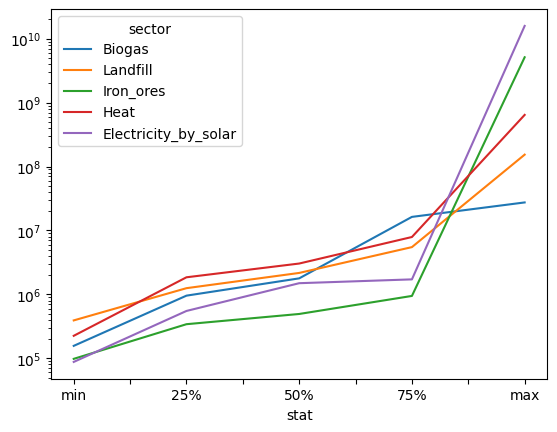

In [5]:
SCENARIO="IMACLIM_all_2050_INDC"

sectors_selection_criterion="std"   # from max,std,mean
sectors_number=5


emissivity_dataframe=pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat"))

SECTORS_INDEX=emissivity_dataframe.loc[(SCENARIO,sectors_selection_criterion)].argsort()[-sectors_number:]
SECTORS=emissivity_dataframe.columns[SECTORS_INDEX]

emissivity_dataframe.loc[emissivity_dataframe.index.get_level_values("stat").isin(["min","25%","50%","75%","max"])].loc[SCENARIO,SECTORS].plot(logy=True)

In [90]:
list_emissi_stat={}
for counterfactual in tqdm.tqdm(model.get_counterfactuals_list()):
    iot=model.counterfactuals[counterfactual].iot
    emissiv_df=pd.DataFrame([iot.stressor_extension.M.sum(),get_total_imports_region(iot,"FR")],index=["emissivity","quantity"]).T
    emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
    emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
    list_emissi_stat[counterfactual]=emissiv_df_stat
    

emissiv_df=pd.DataFrame([model.iot.stressor_extension.M.sum(),get_total_imports_region(model.iot,"FR")],index=["emissivity","quantity"]).T
emissiv_df["rel_quantity"]=emissiv_df["quantity"]/emissiv_df["quantity"].groupby("sector").sum()*1000000
emissiv_df_stat=emissiv_df["emissivity"].repeat(emissiv_df["rel_quantity"]).groupby("sector").describe().T
list_emissi_stat["base"]=emissiv_df_stat


pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat")).to_excel('../Outputs/French_imports_emissivity_stats.xlsx')


100%|██████████| 7/7 [00:49<00:00,  7.03s/it]


In [112]:
SCENARIO="IMACLIM_all_2050_INDC"

sectors_selection_criterion="max"   # from max,std,mean
sectors_number=10


emissivity_dataframe=pd.concat([list_emissi_stat[key] for key in list_emissi_stat.keys()],keys=list_emissi_stat.keys(),names=("scenario","stat"))

SECTORS_INDEX=emissivity_dataframe.loc[(SCENARIO,sectors_selection_criterion)].argsort()[-sectors_number:]
SECTORS=emissivity_dataframe.columns[SECTORS_INDEX]

emissivity_dataframe.loc[emissivity_dataframe.index.get_level_values("stat").isin(["min","25%","50%","75%","max"])].loc[SCENARIO,SECTORS].plot(log_y=True)

In [120]:
import plotly.express as px
emissiv_df=pd.DataFrame([model.iot.stressor_extension.M.sum(),get_total_imports_region(model.iot,"FR")],index=["emissivity","quantity"]).T
emissiv_df_sorted=emissiv_df.sort_values(by="emissivity")
sector_needed_emssiv=emissiv_df_sorted.loc[emissiv_df_sorted.index.get_level_values("sector").isin(SECTORS.to_list())].reset_index()

sector_needed_emssiv=sector_needed_emssiv.drop(index=sector_needed_emssiv.loc[sector_needed_emssiv["quantity"]==0].index)

fig=px.ecdf(sector_needed_emssiv,y="emissivity",color="sector",x="quantity",orientation="h",log_y=True,hover_data=["region","emissivity","quantity"])

fig.show()

In [117]:
emissiv_df["quantity"].groupby("sector").sum()

sector
Air_transport                   8935.520336
Aluminium_ores                    96.340709
Animal_Products                 7160.096088
Biofuels                          17.019586
Biogas                             0.111627
                                   ...     
Vegetables, fruit, nuts         6947.430017
Water_Other_waste_Treatment      340.598394
Water_transport                18076.143973
Wheat                            213.418065
Wood_Waste_incineration           39.089024
Name: quantity, Length: 87, dtype: float64

### Plot footprint of scenarios

<AxesSubplot:>

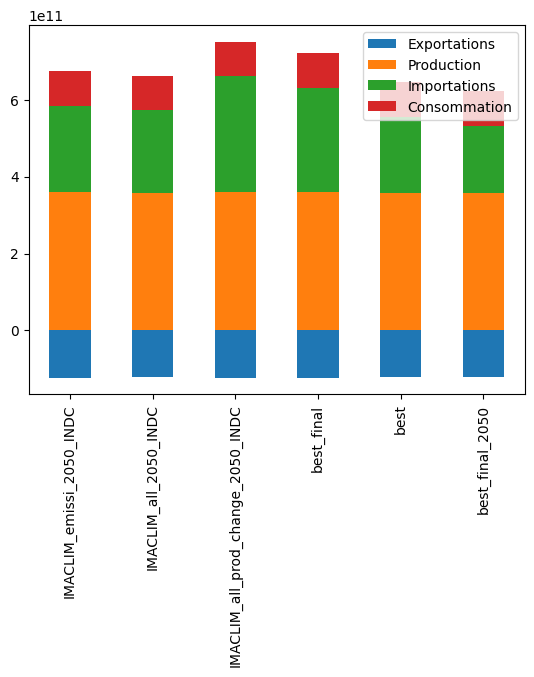

In [6]:

pd.concat([pd.Series(footprint_extractor(model.counterfactuals[counterfactual],"FR")) for counterfactual in model.get_counterfactuals_list() if counterfactual!='IMACLIM_all_prod_change_2050_INDC'],axis=1,keys=model.get_counterfactuals_list()).T.plot(kind="bar",stacked=True)



### Sensitivity analysis of CoefRow change based on final demands 

In [65]:
iot=model.counterfactuals["IMACLIM_emissi_2050_INDC2030_1000"].iot
CoefRoW=get_import_mean_stressor(iot,"FR")
temp_iot=iot.copy()
res=[]
for index in tqdm.tqdm(iot.Y.index):
    temp_Y=iot.Y.copy()
    temp_Y.loc[index,("United States","Final consumption expenditure by households")]+=temp_Y.loc[index].sum()*1
    temp_iot.reset_to_coefficients()
    temp_iot.Y=temp_Y
    temp_iot.calc_all()
    res.append(((get_import_mean_stressor(temp_iot,"FR")-CoefRoW)/CoefRoW))
    

100%|██████████| 3773/3773 [21:02<00:00,  2.99it/s]


In [66]:
res_df=pd.DataFrame(res,index=iot.Y.index)
res_df_fr=res_df.copy()
res_df_fr.loc["FR"]=0
pd.DataFrame([res_df.max(axis=0).loc["CO2"],res_df_fr.max(axis=0).loc["CO2"]],index=["with FR","without FR"])


sector,Air_transport,Aluminium_ores,Animal_Products,Biofuels,Biogas,Chemicals,Clothing_Industry,Coal,Coal-fired_electricity,Computers_communication_equipments,...,Secondary_Other_metals,Secondary_Plastics,Secondary_Pulp_and_paper,Secondary_Steel_iron,Secondary_Wood,Stone,Vegetable_Products,Water_Other_waste_Treatment,Water_transport,Wood_Waste_incineration
with FR,3.531583e-16,1.544184e-14,0.003664,0.000689,2.580279e-14,0.001889,0.004631,0.031327,2.297564e-16,0.00024,...,NaN,NaN,NaN,NaN,NaN,2.307280e-14,0.005223,0.000021,0.000085,9.326421e-15
without FR,3.531583e-16,2.394083e-16,0.000175,0.000076,3.794528e-16,0.000051,0.000147,0.000190,2.297564e-16,0.00001,...,0.0,0.0,0.0,0.0,0.0,6.469008e-16,0.000254,0.000001,0.000002,4.974091e-16


In [68]:
pd.DataFrame([res_df.max(axis=0).loc["CO2"],res_df_fr.max(axis=0).loc["CO2"]],index=["with FR","without FR"]).max(axis=1)


with FR       0.031327
without FR    0.000523
dtype: float64

In [10]:
model.iot.stressor_extension.S@model.iot.L

region    Austria                                                           \
sector Paddy rice          Wheat Cereal grains nec Vegetables, fruit, nuts   
CO2           0.0  832099.331411     416392.789571           156723.516872   
CH4           0.0   47196.876775      41244.061166            18550.084641   
N2O           0.0  850626.732098     544900.209090            71935.030775   
SF6           0.0    3042.211396       2913.801145             1704.439422   
HFC           0.0   79365.963693      78748.303333            36847.080534   
PFC           0.0  122561.918129     119471.166629            55356.575304   

region                                                           \
sector      Oil seeds Sugar cane, sugar beet Plant-based fibers   
CO2     387412.916063          263944.616931       41608.651565   
CH4      24727.841789           25513.060412        2766.729734   
N2O     852249.534107          603232.382821      300478.862143   
SF6       1799.489659           15202.408341          98.381754   
HFC      38024.725776          506514.385324         793.335839   
PFC      55767.799027          773345.494924        1025.391772   

region                                              ... RoW Middle East  \
sector      Crops nec  Farm_animals       Forestry  ...   Air_transport   
CO2     256506.989563  3.316405e+05  159999.179550  ...    2.739039e+06   
CH4      56392.793123  1.972513e+06   30392.758278  ...    6.219835e+04   
N2O     167286.238994  5.302199e+05   17092.750347  ...    4.406544e+04   
SF6      12416.242153  4.972533e+03    8709.950625  ...    3.951672e+02   
HFC     337902.499274  7.032755e+04  221995.605870  ...    2.276876e+03   
PFC     539137.191270  6.870564e+04  329175.784173  ...    5.432513e+02   

region                                                                 \
sector Wood_Waste_incineration Other_Waste_incineration      Landfill   
CO2               1.184395e+06             1.131557e+06  1.004687e+06   
CH4               3.206686e+05             3.684967e+05  1.174967e+07   
N2O               7.396881e+04             6.699214e+04  5.355065e+04   
SF6               2.790932e+03             3.196961e+03  1.041698e+04   
HFC               1.328547e+04             1.517944e+04  4.934033e+04   
PFC               1.476781e+03             1.744967e+03  3.697796e+03   

region                                                              \
sector Water_Other_waste_Treatment    Real estate Hotel_Restaurant   
CO2                  834370.076256  379805.263212    296990.100117   
CH4                  411760.289959   57665.602009     89901.344198   
N2O                   33875.881506   10663.801456     31967.111474   
SF6                   93803.077388     435.685397       418.115942   
HFC                  438418.362367    2285.104477      2434.526534   
PFC                   29741.345492     386.809151       332.055655   

region                                                         
sector       Commerce Other_Business_Services Public_Services  
CO2     228157.219883           585940.780799   374894.070844  
CH4      37220.133608            74163.647856    84002.025300  
N2O       6105.228739            15601.601916    15408.865705  
SF6        236.199430              384.556593      564.056340  
HFC       1299.855625             2114.784358     3547.997248  
PFC        282.095841              420.623676      573.835864  

[6 rows x 4263 columns]

In [70]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.stressor_extension.S

region    Austria                                                           \
sector Paddy rice          Wheat Cereal grains nec Vegetables, fruit, nuts   
CO2             0  268732.293190     120622.778922            25769.307953   
CH4             0     851.156700        519.465431              176.960741   
N2O             0  817211.040789     533672.061525            62441.880373   
SF6             0    2144.563511       2125.373083              915.952165   
HFC             0   70107.854630      71326.116356            29540.878753   
PFC             0  114082.841035     113891.429475            47610.902336   

region                                                           \
sector      Oil seeds Sugar cane, sugar beet Plant-based fibers   
CO2     122100.624709           65067.523654       10487.722403   
CH4        758.976397             497.808857          82.585009   
N2O     845963.937891          569008.605306      299571.955486   
SF6       1022.961075           13779.941996           0.000000   
HFC      32522.272039          474403.610882           0.000000   
PFC      53263.366033          728516.849910           0.000000   

region                                              ... RoW Middle East  \
sector      Crops nec  Farm_animals       Forestry  ...   Air_transport   
CO2     -29420.233768  5.740863e+04   15540.836933  ...    1.546197e+06   
CH4        185.404804  1.864531e+06    1293.069099  ...    1.533334e+02   
N2O     159851.747572  4.683195e+05    8413.211575  ...    3.220244e+04   
SF6      11202.087644  8.458450e+02    3804.121358  ...    5.559213e-02   
HFC     327997.348033  2.718720e+04  118545.111065  ...    1.929846e-01   
PFC     531692.819824  4.496283e+04  186383.873403  ...    1.294082e-02   

region                                                                 \
sector Wood_Waste_incineration Other_Waste_incineration      Landfill   
CO2              516475.223668            478843.461771  8.456410e+04   
CH4               71397.205813             60899.900635  1.132541e+07   
N2O               51146.081403             43881.395180  1.182622e+04   
SF6                 451.086429               429.290807  8.605230e+03   
HFC                1981.343094              1880.109298  4.007167e+04   
PFC                 217.245954               339.923870  2.704770e+03   

region                                                             \
sector Water_Other_waste_Treatment   Real estate Hotel_Restaurant   
CO2                  155498.363605  45101.324562     10894.629171   
CH4                   22222.767272   5275.038535      6396.259402   
N2O                   14509.851237    961.216008      2267.409193   
SF6                   90837.901132     28.073622         5.614781   
HFC                  424193.790180    123.066094        24.156083   
PFC                   28309.226175     16.113249         4.790730   

region                                                        
sector      Commerce Other_Business_Services Public_Services  
CO2     17786.873681           115180.944406     7518.328372  
CH4      4084.463636            11516.104753     1850.374092  
N2O       653.619990             2378.495123      200.919215  
SF6        12.391408               22.493427        1.952957  
HFC        51.660310               98.552421        7.973267  
PFC        15.089892               17.711794        5.834999  

[6 rows x 4263 columns]

In [73]:
model.iot.stressor_extension.M=None

In [12]:
model.iot.A.sum(axis=1)

region           sector                 
Austria          Paddy rice                 0.000000
                 Wheat                      0.054163
                 Cereal grains nec          0.101688
                 Vegetables, fruit, nuts    0.106172
                 Oil seeds                  0.010295
                                              ...   
RoW Middle East  Real estate                0.548047
                 Hotel_Restaurant           1.273994
                 Commerce                   6.756831
                 Other_Business_Services    6.959924
                 Public_Services            0.183809
Length: 4263, dtype: float64

In [75]:
model.iot.stressor_extension.M

region    Austria                                                           \
sector Paddy rice          Wheat Cereal grains nec Vegetables, fruit, nuts   
CO2           0.0  832099.331411     416392.789571           156723.516872   
CH4           0.0   47196.876775      41244.061166            18550.084641   
N2O           0.0  850626.732098     544900.209090            71935.030775   
SF6           0.0    3042.211396       2913.801145             1704.439422   
HFC           0.0   79365.963693      78748.303333            36847.080534   
PFC           0.0  122561.918129     119471.166629            55356.575304   

region                                                           \
sector      Oil seeds Sugar cane, sugar beet Plant-based fibers   
CO2     387412.916063          263944.616931       41608.651565   
CH4      24727.841789           25513.060412        2766.729734   
N2O     852249.534107          603232.382821      300478.862143   
SF6       1799.489659           15202.408341          98.381754   
HFC      38024.725776          506514.385324         793.335839   
PFC      55767.799027          773345.494924        1025.391772   

region                                              ... RoW Middle East  \
sector      Crops nec  Farm_animals       Forestry  ...   Air_transport   
CO2     256506.989563  3.316405e+05  159999.179550  ...    2.739039e+06   
CH4      56392.793123  1.972513e+06   30392.758278  ...    6.219835e+04   
N2O     167286.238994  5.302199e+05   17092.750347  ...    4.406544e+04   
SF6      12416.242153  4.972533e+03    8709.950625  ...    3.951672e+02   
HFC     337902.499274  7.032755e+04  221995.605870  ...    2.276876e+03   
PFC     539137.191270  6.870564e+04  329175.784173  ...    5.432513e+02   

region                                                                 \
sector Wood_Waste_incineration Other_Waste_incineration      Landfill   
CO2               1.184395e+06             1.131557e+06  1.004687e+06   
CH4               3.206686e+05             3.684967e+05  1.174967e+07   
N2O               7.396881e+04             6.699214e+04  5.355065e+04   
SF6               2.790932e+03             3.196961e+03  1.041698e+04   
HFC               1.328547e+04             1.517944e+04  4.934033e+04   
PFC               1.476781e+03             1.744967e+03  3.697796e+03   

region                                                              \
sector Water_Other_waste_Treatment    Real estate Hotel_Restaurant   
CO2                  834370.076256  379805.263212    296990.100117   
CH4                  411760.289959   57665.602009     89901.344198   
N2O                   33875.881506   10663.801456     31967.111474   
SF6                   93803.077388     435.685397       418.115942   
HFC                  438418.362367    2285.104477      2434.526534   
PFC                   29741.345492     386.809151       332.055655   

region                                                         
sector       Commerce Other_Business_Services Public_Services  
CO2     228157.219883           585940.780799   374894.070844  
CH4      37220.133608            74163.647856    84002.025300  
N2O       6105.228739            15601.601916    15408.865705  
SF6        236.199430              384.556593      564.056340  
HFC       1299.855625             2114.784358     3547.997248  
PFC        282.095841              420.623676      573.835864  

[6 rows x 4263 columns]

In [80]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.stressor_extension.M=None

In [81]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.calc_all()

In [85]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.stressor_extension.M.loc[:,("Austria","Paddy rice")]

CO2    0.0
CH4    0.0
N2O    0.0
SF6    0.0
HFC    0.0
PFC    0.0
Name: (Austria, Paddy rice), dtype: float64

In [83]:
model.counterfactuals["IMACLIM_all_2050_INDC"].iot.stressor_extension.S

region    Austria                                                           \
sector Paddy rice          Wheat Cereal grains nec Vegetables, fruit, nuts   
CO2             0  268732.293190     120622.778922            25769.307953   
CH4             0     851.156700        519.465431              176.960741   
N2O             0  817211.040789     533672.061525            62441.880373   
SF6             0    2144.563511       2125.373083              915.952165   
HFC             0   70107.854630      71326.116356            29540.878753   
PFC             0  114082.841035     113891.429475            47610.902336   

region                                                           \
sector      Oil seeds Sugar cane, sugar beet Plant-based fibers   
CO2     122100.624709           65067.523654       10487.722403   
CH4        758.976397             497.808857          82.585009   
N2O     845963.937891          569008.605306      299571.955486   
SF6       1022.961075           13779.941996           0.000000   
HFC      32522.272039          474403.610882           0.000000   
PFC      53263.366033          728516.849910           0.000000   

region                                              ... RoW Middle East  \
sector      Crops nec  Farm_animals       Forestry  ...   Air_transport   
CO2     -29420.233768  5.740863e+04   15540.836933  ...    1.546197e+06   
CH4        185.404804  1.864531e+06    1293.069099  ...    1.533334e+02   
N2O     159851.747572  4.683195e+05    8413.211575  ...    3.220244e+04   
SF6      11202.087644  8.458450e+02    3804.121358  ...    5.559213e-02   
HFC     327997.348033  2.718720e+04  118545.111065  ...    1.929846e-01   
PFC     531692.819824  4.496283e+04  186383.873403  ...    1.294082e-02   

region                                                                 \
sector Wood_Waste_incineration Other_Waste_incineration      Landfill   
CO2              516475.223668            478843.461771  8.456410e+04   
CH4               71397.205813             60899.900635  1.132541e+07   
N2O               51146.081403             43881.395180  1.182622e+04   
SF6                 451.086429               429.290807  8.605230e+03   
HFC                1981.343094              1880.109298  4.007167e+04   
PFC                 217.245954               339.923870  2.704770e+03   

region                                                             \
sector Water_Other_waste_Treatment   Real estate Hotel_Restaurant   
CO2                  155498.363605  45101.324562     10894.629171   
CH4                   22222.767272   5275.038535      6396.259402   
N2O                   14509.851237    961.216008      2267.409193   
SF6                   90837.901132     28.073622         5.614781   
HFC                  424193.790180    123.066094        24.156083   
PFC                   28309.226175     16.113249         4.790730   

region                                                        
sector      Commerce Other_Business_Services Public_Services  
CO2     17786.873681           115180.944406     7518.328372  
CH4      4084.463636            11516.104753     1850.374092  
N2O       653.619990             2378.495123      200.919215  
SF6        12.391408               22.493427        1.952957  
HFC        51.660310               98.552421        7.973267  
PFC        15.089892               17.711794        5.834999  

[6 rows x 4263 columns]

In [25]:
iot=model.iot
iot.Z.dot(np.diag(1/model.iot.x["indout"].transpose()))

0             1             2     \
region          sector                                                      
Austria         Paddy rice                NaN  0.000000e+00  0.000000e+00   
                Wheat                     NaN  3.297235e-02  0.000000e+00   
                Cereal grains nec         NaN  0.000000e+00  1.467618e-02   
                Vegetables, fruit, nuts   NaN  0.000000e+00  0.000000e+00   
                Oil seeds                 NaN  0.000000e+00  0.000000e+00   
...                                       ...           ...           ...   
RoW Middle East Real estate               NaN  1.083429e-06  9.850312e-07   
                Hotel_Restaurant          NaN  1.559697e-05  1.425881e-05   
                Commerce                  NaN  1.065614e-05  7.073383e-06   
                Other_Business_Services   NaN  3.358780e-04  3.006107e-04   
                Public_Services           NaN  1.566461e-07  1.435798e-07   

                                                 3             4     \
region          sector                                                
Austria         Paddy rice               0.000000e+00  0.000000e+00   
                Wheat                    0.000000e+00  0.000000e+00   
                Cereal grains nec        0.000000e+00  0.000000e+00   
                Vegetables, fruit, nuts  7.232664e-02  0.000000e+00   
                Oil seeds                0.000000e+00  3.915943e-03   
...                                               ...           ...   
RoW Middle East Real estate              9.541257e-07  5.375929e-07   
                Hotel_Restaurant         1.394905e-05  7.973566e-06   
                Commerce                 5.310118e-06  1.110521e-05   
                Other_Business_Services  2.573084e-04  1.717035e-04   
                Public_Services          1.409723e-07  8.124841e-08   

                                                 5             6     \
region          sector                                                
Austria         Paddy rice               0.000000e+00  0.000000e+00   
                Wheat                    0.000000e+00  0.000000e+00   
                Cereal grains nec        0.000000e+00  0.000000e+00   
                Vegetables, fruit, nuts  0.000000e+00  0.000000e+00   
                Oil seeds                0.000000e+00  0.000000e+00   
...                                               ...           ...   
RoW Middle East Real estate              1.153877e-06  6.279709e-08   
                Hotel_Restaurant         1.681642e-05  0.000000e+00   
                Commerce                 1.833526e-05  1.672716e-05   
                Other_Business_Services  3.644505e-04  4.286416e-05   
                Public_Services          1.698833e-07  0.000000e+00   

                                                 7             8     \
region          sector                                                
Austria         Paddy rice               0.000000e+00  0.000000e+00   
                Wheat                    2.841906e-03  2.907409e-03   
                Cereal grains nec        2.155843e-03  4.541870e-02   
                Vegetables, fruit, nuts  0.000000e+00  2.766029e-04   
                Oil seeds                0.000000e+00  0.000000e+00   
...                                               ...           ...   
RoW Middle East Real estate              1.082516e-06  1.076605e-06   
                Hotel_Restaurant         1.556570e-05  1.652747e-05   
                Commerce                 8.992249e-06  1.076951e-05   
                Other_Business_Services  3.334701e-04  3.132007e-04   
                Public_Services          1.562246e-07  1.711307e-07   

                                                 9     ...          4253  \
region          sector                                 ...                 
Austria         Paddy rice               0.000000e+00  ...  0.000000e+00   
                Wheat                  

region                                     Austria                \
sector                                  Paddy rice         Wheat   
region          sector                                             
Austria         Paddy rice                     NaN  0.000000e+00   
                Wheat                          NaN  3.297235e-02   
                Cereal grains nec              NaN  0.000000e+00   
                Vegetables, fruit, nuts        NaN  0.000000e+00   
                Oil seeds                      NaN  0.000000e+00   
...                                            ...           ...   
RoW Middle East Real estate                    NaN  1.083429e-06   
                Hotel_Restaurant               NaN  1.559697e-05   
                Commerce                       NaN  1.065614e-05   
                Other_Business_Services        NaN  3.358780e-04   
                Public_Services                NaN  1.566461e-07   

region                                                     \
sector                                  Cereal grains nec   
region          sector                                      
Austria         Paddy rice                   0.000000e+00   
                Wheat                        0.000000e+00   
                Cereal grains nec            1.467618e-02   
                Vegetables, fruit, nuts      0.000000e+00   
                Oil seeds                    0.000000e+00   
...                                                   ...   
RoW Middle East Real estate                  9.850312e-07   
                Hotel_Restaurant             1.425881e-05   
                Commerce                     7.073383e-06   
                Other_Business_Services      3.006107e-04   
                Public_Services              1.435798e-07   

region                                                                         \
sector                                  Vegetables, fruit, nuts     Oil seeds   
region          sector                                                          
Austria         Paddy rice                         0.000000e+00  0.000000e+00   
                Wheat                              0.000000e+00  0.000000e+00   
                Cereal grains nec                  0.000000e+00  0.000000e+00   
                Vegetables, fruit, nuts            7.232664e-02  0.000000e+00   
                Oil seeds                          0.000000e+00  3.915943e-03   
...                                                         ...           ...   
RoW Middle East Real estate                        9.541257e-07  5.375929e-07   
                Hotel_Restaurant                   1.394905e-05  7.973566e-06   
                Commerce                           5.310118e-06  1.110521e-05   
                Other_Business_Services            2.573084e-04  1.717035e-04   
                Public_Services                    1.409723e-07  8.124841e-08   

region                                                          \
sector                                  Sugar cane, sugar beet   
region          sector                                           
Austria         Paddy rice                        0.000000e+00   
                Wheat                             0.000000e+00   
                Cereal grains nec                 0.000000e+00   
                Vegetables, fruit, nuts           0.000000e+00   
                Oil seeds                         0.000000e+00   
...                                                        ...   
RoW Middle East Real estate                       1.153877e-06   
                Hotel_Restaurant                  1.681642e-05   
                Commerce                          1.833526e-05   
                Other_Business_Services           3.644505e-04   
                Public_Services                   1.698833e-07   

region                                                                    \
sector                                  Plant-based fibe

In [9]:
from  src.utils import recal_stressor_per_region

In [4]:
model.iot.stressor_extension.S

region                     AFR                                              \
sector             Agriculture            Air          Coal   Construction   
CO2 - combustion  5.338270e+04  718425.561130  1.092772e+06  123256.048928   
CO2 - other       9.113891e+03    3014.766753  1.190153e+04  180310.276770   
CH4               1.438156e+06  156162.396902  5.993423e+06   32223.863588   
N2O               7.412611e+05    9915.360848  5.435496e+04   13162.671975   
SF6               6.388987e+02     202.924811  2.732942e+04     149.210570   
HFC               1.155491e+03     286.595098  4.808112e+04     250.291199   
PFC               0.000000e+00       0.809023  9.887138e+01       1.139764   

region                                                                      \
sector                    Elec           Gas       Industry   Liquid fuels   
CO2 - combustion  7.746222e+06  1.260003e+06  204938.884015  314074.001139   
CO2 - other       1.024044e+04  7.750485e+03   14323.652732    1956.712774   
CH4               2.633629e+05  2.144745e+06  546369.293288  621547.274966   
N2O               1.185237e+05  6.125344e+04   66958.410857    2294.894445   
SF6               3.473807e+02  8.549382e+02    1865.042080     907.560927   
HFC               3.623205e+02  1.432695e+03    2489.238083    1448.976735   
PFC               5.991351e+01  8.875786e+01    2547.538582       5.673486   

region                                         ...            USA  \
sector                 Maritime           Oil  ...           Coal   
CO2 - combustion  119525.403970  1.108133e+05  ...  313761.510105   
CO2 - other          688.000472  7.053872e+02  ...       0.012072   
CH4                  435.660192  2.735771e+06  ...  991827.323658   
N2O                  185.641279  2.576261e+03  ...    1667.072915   
SF6                    0.000397  1.909239e+01  ...    9612.065050   
HFC                    0.000387  2.010027e+01  ...  180650.864713   
PFC                    0.000000  3.939628e+00  ...    1284.072312   

region                                                                    \
sector            Construction          Elec           Gas      Industry   
CO2 - combustion  43709.621684  5.275312e+06  1.222799e+06  95280.486048   
CO2 - other       46105.364056  0.000000e+00  6.129270e-02    364.664269   
CH4                  45.961185  6.713527e+03  4.265038e+05  27221.768345   
N2O                 192.468790  4.536317e+04  6.891534e+03   1336.049292   
SF6                  36.164977  3.534529e+01  7.864493e+02   3193.988056   
HFC                 680.681172  6.861315e+02  1.768406e+04  56458.952683   
PFC                   5.622858  4.633899e+00  1.651439e+02    793.719056   

region                                                                      \
sector             Liquid fuels       Maritime           Oil      Services   
CO2 - combustion  368557.509974  765322.677532  4.911334e+05  11518.050602   
CO2 - other           21.088256       0.000000  4.418218e-01      3.587393   
CH4                96793.628352     610.619636  1.056062e+06    221.607741   
N2O                 1389.441272    2729.740171  5.247934e+02    106.349177   
SF6                  772.533336       0.000000  4.914951e+02      0.147536   
HFC                15454.879006       0.000000  1.132163e+04      2.835346   
PFC                  136.550856       0.000000  1.074361e+02      0.019307   

region                                  
sector           Terrestrial transport  
CO2 - combustion         123626.630078  
CO2 - other                   1.981176  
CH4                        8282.570468  
N2O                        1165.575399  
SF6                          74.719605  
HFC                        1533.099886  
PFC                          13.951980  

[7 rows x 144 columns]

AttributeError: 'list' object has no attribute 'drop'